# **Blackjack Strategy Simulation**
Julie Chen

In [ ]:
import numpy as np
import pandas as pd
import random
from enum import Enum
from typing import Optional
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

random.seed(6644)

In [ ]:
## Chart Strategy DataFrames
dealer_upcard = [2, 3, 4, 5, 6, 7, 8, 9, 10, 1]
hard_totals = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
               [2, 2, 2, 2, 2, 1, 1, 1, 1, 1],
               [2, 2, 2, 2, 2, 1, 1, 1, 1, 1],
               [2, 2, 2, 2, 2, 1, 1, 1, 1, 1],
               [2, 2, 2, 2, 2, 1, 1, 1, 1, 1],
               [1, 1, 2, 2, 2, 1, 1, 1, 1, 1],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

hard_df = pd.DataFrame(hard_totals, columns = dealer_upcard,
                       index = [17, 16, 15, 14, 13, 12, 11, 10, 9, 8])

soft_totals = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
               [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
               [2, 2, 2, 2, 2, 2, 2, 1, 1, 1],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

soft_df = pd.DataFrame(soft_totals, columns = dealer_upcard,
                       index = [20, 19, 18, 17, 16, 15, 14, 13, 12])

In [ ]:
class Strategy(Enum):
  DEALER = 0 # hit <=16, hit on soft 17
  SIMPLE_STRATEGY = 1 # hit <=16
  RANDOM_STRATEGY = 2 # 50/50 hit/stand
  BICYCLE_STRATEGY = 3 # follow https://bicyclecards.com/how-to-play/blackjack/ strategy
  CHART_STRATEGY = 4 # https://www.blackjackapprenticeship.com/blackjack-strategy-charts/
  ALWAYS_HIT = 5

class Action(Enum):
  HIT = 1
  STAND = 2

class RoundResult(Enum):
  WIN = 1
  LOSE = 2
  TIE = 3

In [ ]:
class Card:
  def __init__(self, value):
    self.value = value
  def __repr__(self):
    return str(self.value)
  def card_score(self):
    return min(10, self.value)

In [ ]:
class Player:
  def __init__(self, strategy: Strategy = Strategy.SIMPLE_STRATEGY, hand: Optional[list[Card]] = None) -> None:
    self.hand = hand if hand else []
    self.strategy = strategy
    self.rounds_won = 0
    self.rounds_lost = 0
    self.money_delta = 0

  def add_card(self, card) -> None:
    self.hand.append(card)

  def dispose(self) -> list[Card]:
    hand_copy = self.hand
    self.hand = []
    return hand_copy

  def calculate_score_list(self) -> list:
    card_values = [card.card_score() for card in self.hand]
    num_aces = card_values.count(1)
    return sorted([sum(card_values) + i * 10 for i in range(0, num_aces + 1)], reverse = True)

  def best_score(self) -> int:
    score_list = self.calculate_score_list()
    for score in score_list:
      if score <= 21:
        return score
    return score_list[-1]

  def win_ratio(self) -> float:
    # draws or "pushes" do not count by rules of blackjack
    return self.rounds_won / (self.rounds_won + self.rounds_lost)

  def next_move(self, dealer_top_card: Optional[Card] = None) -> Action:
    possible_scores = self.calculate_score_list()
    best_score = self.best_score()
    is_soft = (best_score > possible_scores[-1])

    if self.strategy == Strategy.ALWAYS_HIT:
      return Action.HIT if best_score <= 21 else Action.STAND

    if best_score >= 21:
      # always stop at 21
      return Action.STAND

    if self.strategy == Strategy.DEALER:
      if best_score <= 16:
        return Action.HIT
      elif best_score == 17 and is_soft: #soft 17
        return Action.HIT
      else:
        return Action.STAND

    if self.strategy == Strategy.SIMPLE_STRATEGY:
      if best_score <= 16:
        return Action.HIT
      else:
        return Action.STAND

    if self.strategy == Strategy.RANDOM_STRATEGY:
      if random.random() < 0.5:
        return Action.HIT
      return Action.STAND

    if self.strategy == Strategy.BICYCLE_STRATEGY:
      if is_soft and best_score < 18: # always hit on a soft hand <18
        return Action.HIT

      if dealer_top_card.value >= 7 or dealer_top_card.value == 1:
        return Action.HIT if best_score < 17 else Action.STAND

      if 4 <= dealer_top_card.value <= 6:
        return Action.HIT if best_score < 12 else Action.STAND

      return Action.HIT if best_score < 13 else Action.STAND

    if self.strategy == Strategy.CHART_STRATEGY:
      # check if 21:
      if best_score == 21:
        return Action.STAND
      # check if hand is soft (has Ace)
      if is_soft:
        return Action(soft_df.loc[best_score, dealer_top_card.card_score()])
      if best_score > 17:
        return Action.STAND
      if best_score < 8:
        return Action.HIT
      else:
        try:
          return Action(hard_df.loc[best_score, dealer_top_card.card_score()])
        except:
          print(best_score, dealer_top_card, dealer_top_card.card_score())
          raise Exception()

  def determine_round_result(self, dealer: "Player") -> Optional[bool]:
    player_score = self.best_score()
    dealer_score = dealer.best_score()
    if player_score > 21: #bust
      return RoundResult.LOSE
    elif dealer_score > 21: #dealer bust
      return RoundResult.WIN
    elif player_score == 21 and dealer_score == 21 and len(self.hand) == 2 and len(dealer.hand) > 2: #natural win
      return RoundResult.WIN
    elif player_score == 21 and dealer_score == 21 and len(self.hand) > 2 and len(dealer.hand) == 2: #natural loss
      return RoundResult.LOSE
    elif player_score > dealer_score: #regular win
      return RoundResult.WIN
    elif player_score < dealer_score: #regular loss
      return RoundResult.LOSE
    else: #draw
      return RoundResult.TIE

  def change_money_amount(self, amount):
    self.money_delta += amount

In [ ]:
class Game:

  def __init__(self, player_list, num_decks):
    # enforce number of players and total number of card decks in each game
    self.dealer = Player(Strategy.DEALER)
    self.players = player_list
    self.num_decks = num_decks
    self.saved_hands = []

  def play_round(self, debug: bool = False):
    # shuffle every round (aka brand new deck)
    deck = [Card(i) for i in range(1, 14) for _ in range(4) for _ in range(self.num_decks)]
    random.shuffle(deck)
    # players place bets
    # dealer deals 2 cards to each player in "order", then himself
    for player in self.players * 2 + [self.dealer] * 2:
      player.add_card(deck.pop())

    # Decide move: hit or stand?
    num_stands = 0
    while(num_stands != len(self.players)):
      num_stands = 0
      for player in self.players:
        next_move = player.next_move(self.dealer.hand[0])
        if debug:
          print(f"Player {next_move.name}s on {player.hand}")
        if next_move == Action.HIT:
          player.add_card(deck.pop())
        else: #STAND
          num_stands += 1

      if debug:
        print("===")


    dealer_stands = False
    while not dealer_stands:
      next_move = self.dealer.next_move(self.dealer.hand[0])
      if debug:
        print(f"Dealer {next_move.name}s on {self.dealer.hand}")
      if next_move == Action.HIT:
        self.dealer.add_card(deck.pop())
      else:
        dealer_stands = True

    current_round_hands = [self.dealer.hand]
    # Calculate round score:
    for player in self.players:
      round_result = player.determine_round_result(self.dealer)
      if round_result == RoundResult.WIN:
        player.rounds_won += 1
        player.change_money_amount(10)
        if len(player.hand) == 2 and player.best_score() == 21:
          player.change_money_amount(5)
      elif round_result == RoundResult.LOSE:
        player.rounds_lost += 1
        player.change_money_amount(-10)


      current_round_hands.append(player.dispose())
    self.dealer.dispose()
    self.saved_hands.append(current_round_hands)

# Simulating 10,000 Rounds of Blackjack with 6 Decks of Cards

In [ ]:
test = Game([Player(Strategy.DEALER), Player(), Player(Strategy.RANDOM_STRATEGY), Player(Strategy.BICYCLE_STRATEGY), Player(Strategy.CHART_STRATEGY)], 6)
NUM_ROUNDS = 10000
t = [test.play_round() for i in range(NUM_ROUNDS)]
#test.play_round(debug=True)

# Strategy Win Rates and Net Earnings

In [ ]:
for i in range(5):
  print(f'Player {i} with {test.players[i].strategy} has a win ratio of {test.players[i].win_ratio()} and earned ${test.players[i].money_delta} over {NUM_ROUNDS} rounds of Blackjack.')

Player 0 with Strategy.DEALER has a win ratio of 0.4489366415595924 and earned $-7265 over 10000 rounds of Blackjack.
Player 1 with Strategy.SIMPLE_STRATEGY has a win ratio of 0.45412130637636083 and earned $-6005 over 10000 rounds of Blackjack.
Player 2 with Strategy.RANDOM_STRATEGY has a win ratio of 0.2794543199669285 and earned $-40160 over 10000 rounds of Blackjack.
Player 3 with Strategy.BICYCLE_STRATEGY has a win ratio of 0.4763779527559055 and earned $-1765 over 10000 rounds of Blackjack.
Player 4 with Strategy.CHART_STRATEGY has a win ratio of 0.47699386503067487 and earned $-1680 over 10000 rounds of Blackjack.


# Graphing Starting Hand Win Likelihoods by Strategy

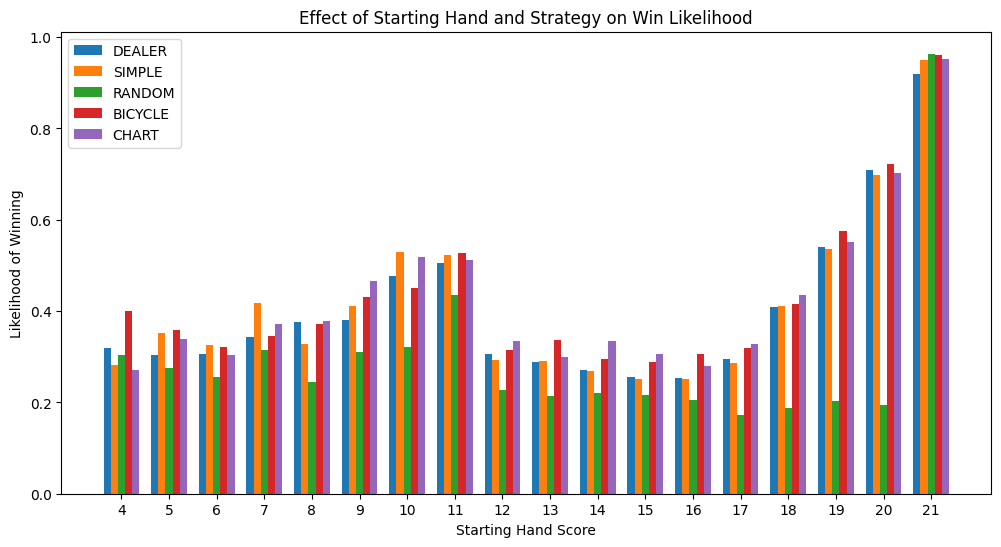

In [ ]:
bar_width = 0.15
multiplier = 0
strat_names = ['DEALER', 'SIMPLE', 'RANDOM', 'BICYCLE', 'CHART']

fig, ax = plt.subplots(figsize = (12, 6))

for strat in range(1, 6):
  opening_score = [Player(hand = test.saved_hands[i][strat][0:2]).best_score() for i in range(len(test.saved_hands))]
  strat_results = [Player(hand = test.saved_hands[i][strat]).determine_round_result(Player(hand = test.saved_hands[i][0])) for i in range(len(test.saved_hands))]
  l = list(zip(opening_score, strat_results))
  c = Counter(l)
  d  = {}
  for starting_score in set(opening_score):
    total_rounds = c[(starting_score, RoundResult.WIN)] + c[(starting_score, RoundResult.LOSE)] + c[(starting_score, RoundResult.TIE)]
    win_ratio = c[(starting_score, RoundResult.WIN)] / total_rounds
    d[starting_score] = win_ratio

  starting_scores, win_likelihood = zip(*d.items())
  x = np.arange(len(starting_scores))
  offset = bar_width * multiplier -0.15
  rects = ax.bar(x + offset, win_likelihood, width = bar_width, label=strat_names[strat - 1])
  multiplier += 1
ax.set_ylabel('Likelihood of Winning')
ax.set_xlabel('Starting Hand Score')
ax.set_title('Effect of Starting Hand and Strategy on Win Likelihood')
plt.xticks([r + bar_width for r in range(len(starting_scores))], starting_scores)
plt.legend()
plt.show()

# Calculating Win Likelihood per Strategy Based on Dealer Upcard

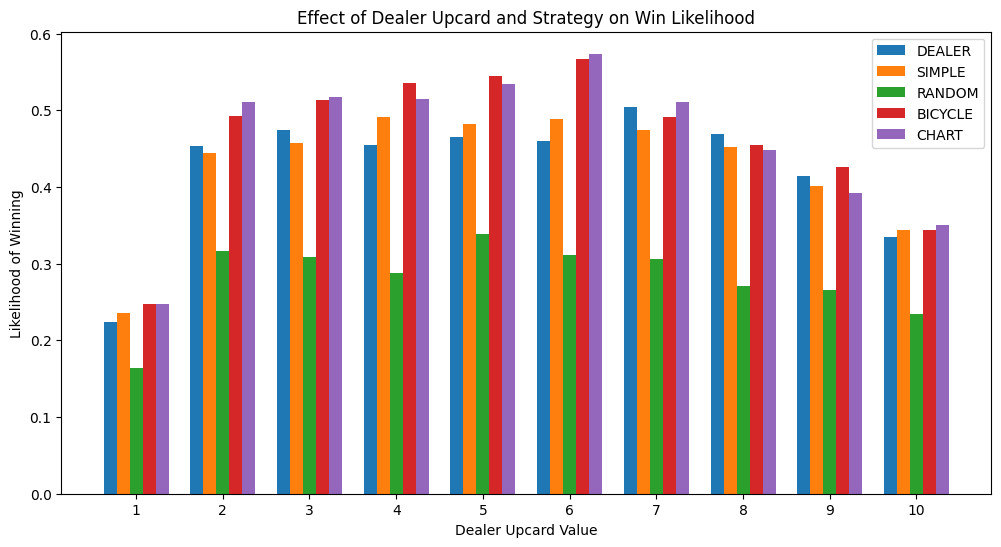

In [ ]:
bar_width = 0.15
multiplier = 0
strat_names = ['DEALER', 'SIMPLE', 'RANDOM', 'BICYCLE', 'CHART']

fig, ax = plt.subplots(figsize = (12, 6))

for strat in range(1, 6):
  upcard_scores = [test.saved_hands[i][0][0].card_score() for i in range(len(test.saved_hands))]
  strat_results = [Player(hand = test.saved_hands[i][strat]).determine_round_result(Player(hand = test.saved_hands[i][0])) for i in range(len(test.saved_hands))]
  l = list(zip(upcard_scores, strat_results))
  c = Counter(l)
  d  = {}
  for upcard in set(upcard_scores):
    total_rounds = c[(upcard, RoundResult.WIN)] + c[(upcard, RoundResult.LOSE)] + c[(upcard, RoundResult.TIE)]
    win_ratio = c[(upcard, RoundResult.WIN)] / total_rounds
    d[upcard] = win_ratio

  dealer_ups, win_likelihood = zip(*d.items())
  x = np.arange(len(dealer_ups))
  offset = bar_width * multiplier -0.15
  rects = ax.bar(x + offset, win_likelihood, width = bar_width, label=strat_names[strat - 1])
  multiplier += 1
ax.set_ylabel('Likelihood of Winning')
ax.set_xlabel('Dealer Upcard Value')
ax.set_title('Effect of Dealer Upcard and Strategy on Win Likelihood')
plt.xticks([r + bar_width for r in range(len(dealer_ups))], dealer_ups)
plt.legend()
plt.show()

# Calculating Win Likelihoods Based on HIT/STAND Decision


In [ ]:
# Play using ALWAYS_HIT strategy to generate chain of cards
hit_player = Player(Strategy.ALWAYS_HIT)
hit_game = Game([hit_player], 1)
for round in range(NUM_ROUNDS):
  hit_game.play_round()

hard_d = defaultdict(lambda: defaultdict(int))
soft_d = defaultdict(lambda: defaultdict(int))

for round_hands in hit_game.saved_hands:
  dealer = Player(hand = round_hands[0])
  me = Player(hand = round_hands[1][0:2])

  res_list = []
  cum_scores = []
  for elem in round_hands[1][2:]:
    res_list.append(me.determine_round_result(dealer))
    my_best_score = me.best_score()
    cum_scores.append((my_best_score, my_best_score > me.calculate_score_list()[-1]))
    me.add_card(elem)

  for i, (score, result) in enumerate(zip(cum_scores, res_list)):
    d = soft_d if score[1] else hard_d
    d[score[0]]['total'] += 1
    if result == RoundResult.WIN:
      d[score[0]]['stand'] += 1
    if RoundResult.WIN in res_list[i+1:]:
      d[score[0]]['hit'] += 1


In [ ]:
# Calculate win percentages based on HIT/STAND choice
hard_hit_rate = {key: hard_d[key]['hit'] / hard_d[key]['total'] for key in hard_d}
hard_stand_rate = {key: hard_d[key]['stand'] / hard_d[key]['total'] for key in hard_d}

soft_hit_rate = defaultdict(float, {key: soft_d[key]['hit'] / soft_d[key]['total'] for key in soft_d})
soft_stand_rate = defaultdict(float, {key: soft_d[key]['stand'] / soft_d[key]['total'] for key in soft_d})

# Graphing HIT/STAND Win Rates

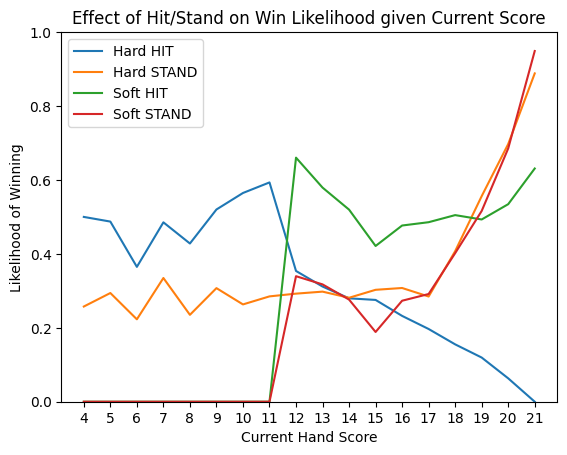

In [ ]:
# Graphing HIT/STAND win rates
x_vals = range(4, 22)
y_hard_hit = [hard_hit_rate[x_val] for x_val in x_vals]
y_hard_stand = [hard_stand_rate[x_val] for x_val in x_vals]
y_soft_hit = [soft_hit_rate[x_val] for x_val in x_vals ]
y_soft_stand = [soft_stand_rate[x_val] for x_val in x_vals]


plt.plot(x_vals, y_hard_hit, label = 'Hard HIT')
plt.plot(x_vals, y_hard_stand, label = 'Hard STAND')
plt.plot(x_vals, y_soft_hit, label = 'Soft HIT')
plt.plot(x_vals, y_soft_stand, label = 'Soft STAND')
plt.ylim(bottom = 0, top = 1)
plt.xticks([r for r in range(4, 22)], range(4, 22))
plt.ylabel("Likelihood of Winning")
plt.xlabel("Current Hand Score")
plt.title("Effect of Hit/Stand on Win Likelihood given Current Score")
plt.legend()
plt.show()